In [5]:
import torch.cuda
import torchvision
from torchvision import transforms,datasets
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# torch.seed=41
import matplotlib.pyplot as plt

In [6]:
train_set = datasets.MNIST('./data', train=True, download=False)
test_set = datasets.MNIST('./data', train=False, download=False)
train_img = train_set.data.numpy()
test_img = test_set.data.numpy()
train_label=train_set.targets.numpy()
test_label=test_set.targets.numpy()
train_label=torch.Tensor(train_label)
test_label=torch.Tensor(test_label)
train_img = train_img.reshape(-1, 28, 28,1)
train_img.shape
# train_label

(60000, 28, 28, 1)

torch.Size([60000, 1, 28, 28])
MNIST Image


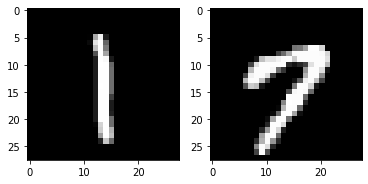

In [7]:
batch_size = 180
train_images = torch.Tensor(train_img).view(train_img.shape[0],1,28,28)
test_images = torch.Tensor(test_img).view(test_img.shape[0],1,28,28)
print(train_images.shape)
print("MNIST Image")
fig, axes = plt.subplots(1,2)
axes[0].imshow(train_img[14],cmap="gray")
axes[1].imshow(train_img[15],cmap="gray")
plt.show()

In [8]:
# batch_size = 400
train_images = torch.Tensor(train_img).view(train_img.shape[0],1,28,28).to(device)
test_images = torch.Tensor(test_img).view(test_img.shape[0],1,28,28).to(device)
train_label=F.one_hot(train_label.to(torch.int64),10).to(device)
test_label=F.one_hot(test_label.to(torch.int64),10).to(device)
train_label.shape

torch.Size([60000, 10])

In [21]:
class AE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
                nn.Linear(794,512).to(device),
                nn.ReLU(),
                nn.Linear(512,256).to(device),
                nn.ReLU(),
                nn.Linear(256,128).to(device),
                nn.ReLU(),
                nn.Linear(128,64).to(device),
                nn.ReLU()
        )
        self.decoder = nn.Sequential(
                nn.Linear(32,64).to(device),
                nn.ReLU(),
                nn.Linear(64,128).to(device),
                nn.ReLU(),
                nn.Linear(128,256).to(device),
                nn.ReLU(),
                nn.Linear(256,512).to(device),
                nn.ReLU(),
                nn.Linear(512,784).to(device),
                nn.ReLU()
        )
    
    def forward(self,x,x_label):
        x=x.view(x.shape[0],-1)
        input_val=x
#         print(x.shape,x_label.shape)
        x=torch.cat((x,x_label),1)
#         print(x.shape)
        x=self.encoder(x)
        mean,std=torch.chunk(x,2,dim=1)
        x = mean + torch.randn_like(std).to(device)*std
        x=self.decoder(x)
#         print(x.shape)
        return input_val,x,mean,std
AutoEncoder = AE()
# AutoEncoder

In [22]:
import torch.optim as optim
optimiser = torch.optim.Adam(AutoEncoder.parameters(), lr=0.005)
loss_list = []

In [23]:
def variational_loss(output,X_in,mean,std):
    loss_function = nn.MSELoss()
    loss_by_function=loss_function(output,X_in)
    kl_loss= -0.005*torch.sum(1+torch.log(torch.pow(std,2)+1e-10)-torch.pow(std,2)-torch.pow(mean,2))
    total_loss=loss_by_function+kl_loss
    return total_loss

In [31]:
def train(X,X_label):
    for epoch in range(0,20):
        cost = 0
#         batch = torch.from_numpy(np.arange(0,X.shape[0],dtype="int64"))
#If you would like to check with arange instead of randperm, then uncomment above and comment below lines respectively
        batch=torch.randperm(X.shape[0])
        for i in range(0, X.shape[0],batch_size):
            input_value,output,mean,std = AutoEncoder(X[batch[i:i+batch_size]].to(device),X_label[batch[i:i+batch_size]].to(device))
            optimiser.zero_grad()
            loss=variational_loss(output,input_value,mean,std)
            cost = cost+loss.item() 
            loss.backward()
            optimiser.step()
        loss_avg = cost / X.shape[0]
        loss_list.append(loss_avg)
        print("For iteration: ", epoch+1, " the loss is :", loss_avg)
#         a=mean.detach().numpy()
#         plt.scatter(a[:,0],a[:,1])
#         break
    return loss_list

For iteration:  1  the loss is : 17.91008721516927
For iteration:  2  the loss is : 18.327495935058593
For iteration:  3  the loss is : 18.432762825520832
For iteration:  4  the loss is : 17.805266723632812
For iteration:  5  the loss is : 17.743521529134114
For iteration:  6  the loss is : 17.313609407552082
For iteration:  7  the loss is : 17.337067106119793
For iteration:  8  the loss is : 17.249230615234374
For iteration:  9  the loss is : 17.22629161783854
For iteration:  10  the loss is : 17.469138505045574
For iteration:  11  the loss is : 17.72248817545573
For iteration:  12  the loss is : 17.63664982910156
For iteration:  13  the loss is : 17.103605611165364
For iteration:  14  the loss is : 16.887898038736978
For iteration:  15  the loss is : 16.659801493326825
For iteration:  16  the loss is : 16.93244103597005
For iteration:  17  the loss is : 16.570082779947917
For iteration:  18  the loss is : 16.352812093098958
For iteration:  19  the loss is : 16.197722639973957
For ite

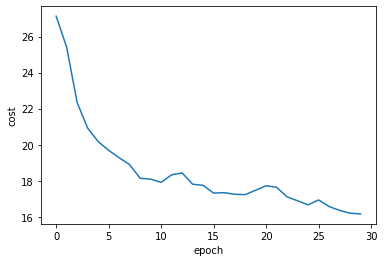

In [32]:
import matplotlib.pyplot as plt
train_loss= train(train_images,train_label)
plt.plot(loss_list)
plt.ylabel('cost')
plt.xlabel('epoch')
plt.show()

In [33]:
def test(X,X_lab):
    with torch.no_grad():
        cost=0
        batch=torch.randperm(X.shape[0])
        for i in range(0, X.shape[0],batch_size):
            test_input,test_output,mean,std=AutoEncoder(X[batch[i:i+batch_size]].to(device),X_lab[batch[i:i+batch_size]].to(device))
            loss=variational_loss(test_output,test_input,mean,std)
            cost=cost+loss.item()
        print(cost/X.shape[0])
test(test_images,test_label)

16.12301579589844


MNIST Image


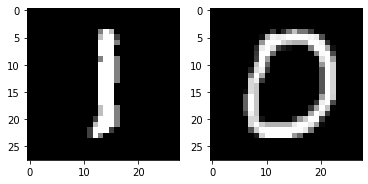

Image through Conditional Variational AutoEncoder


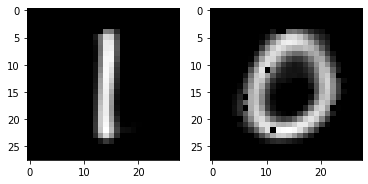

In [38]:
#Normal Image
print("MNIST Image")
fig, axes = plt.subplots(1,2)
axes[0].imshow(test_img[14],cmap="gray")
axes[1].imshow(test_img[10],cmap="gray")

plt.show()

print("Image through Conditional Variational AutoEncoder")
output_imgs=AutoEncoder(test_images[0:40].to(device),test_label[0:40].to(device))
output_img=(output_imgs[1].to(torch.device('cpu')).detach().numpy()).reshape(40,28,28)

fig, axes = plt.subplots(1,2)
axes[0].imshow(output_img[14],cmap="gray")
axes[1].imshow(output_img[10],cmap="gray")
plt.show()

In [35]:
# https://medium.com/@galexik81/5-lifesaving-pytorch-functions-519d134df9b1
#Visit the above blog to know more about torch.chunk